In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch_geometric.transforms as T
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import QM9

from typing import List, Tuple, Optional

In [2]:
dataset = QM9(root='./data/QM9')
print(f'Number of graphs: {len(dataset)}')

Number of graphs: 130831


Data(x=[13, 11], edge_index=[2, 28], edge_attr=[28, 4], y=[1, 19], pos=[13, 3], idx=[1], name='gdb_694', z=[13])
tensor([[ 1.7907e+00,  4.9200e+01, -6.3947e+00,  1.6898e+00,  8.0845e+00,
          4.8005e+02,  2.9658e+00, -7.7942e+03, -7.7941e+03, -7.7941e+03,
         -7.7950e+03,  2.0301e+01, -5.1568e+01, -5.1921e+01, -5.2230e+01,
         -4.7916e+01,  6.8885e+00,  3.5714e+00,  3.0058e+00]])


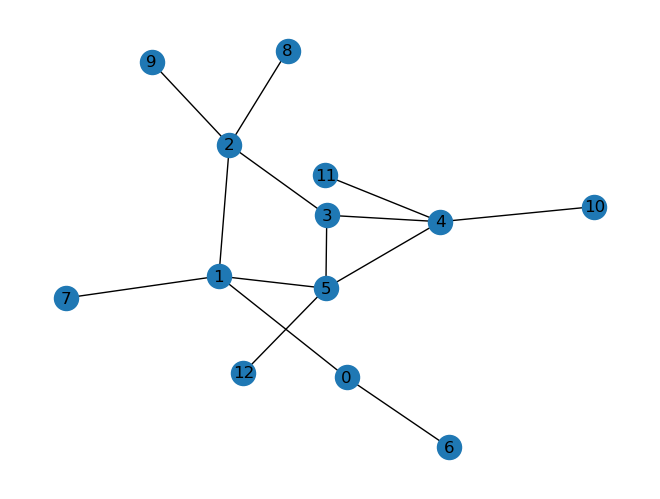

In [4]:
i = 684

print(dataset[i])
print(dataset[i].y)
# print(dataset[i].edge_attr)

g = to_networkx(dataset[i], to_undirected=True)
nx.draw(g, with_labels=True)

In [3]:
def create_train_val_test_nx(dataset: Dataset,
                               train_ratio: float = 0.8,
                               val_ratio: float = 0.1,
                               test_ratio: float = 0.1,
                               subset_size: Optional[int] = None,
                               random_seed: int = 42) -> Tuple[List[nx.Graph], List[nx.Graph], List[nx.Graph], List[Data], List[Data], List[Data]]:
    """
    Splits a PyTorch Geometric dataset into training, validation, and test sets
    of NetworkX graphs and their corresponding PyG Data objects.

    Args:
        dataset: The PyTorch Geometric dataset.
        train_ratio: Proportion of the dataset to allocate for training.
        val_ratio: Proportion of the dataset to allocate for validation.
        test_ratio: Proportion of the dataset to allocate for testing.
        subset_size: Optional. If provided, a random subset of this size will be used from the original dataset.
        random_seed: Seed for shuffling to ensure reproducibility.

    Returns:
        A tuple containing:
            (train_nx, val_nx, test_nx, train_pyg, val_pyg, test_pyg).
    """
    if not (0 < train_ratio < 1 and 0 < val_ratio < 1 and 0 < test_ratio < 1):
        raise ValueError("Ratios must be between 0 and 1.")
    if not np.isclose(train_ratio + val_ratio + test_ratio, 1.0):
        raise ValueError("Sum of ratios must be equal to 1.")

    np.random.seed(random_seed)

    if subset_size is not None and subset_size < len(dataset):
        # Get a permuted list of indices from the original dataset
        indices_full_dataset = np.random.permutation(len(dataset))[:subset_size]
        # Create the current_dataset by slicing the original dataset
        current_dataset = dataset[indices_full_dataset.tolist()]
    else:
        current_dataset = dataset

    num_graphs = len(current_dataset)
    # These indices are local to current_dataset
    permuted_local_indices = np.random.permutation(num_graphs)

    train_end = int(train_ratio * num_graphs)
    val_end = train_end + int(val_ratio * num_graphs)

    train_local_idx = permuted_local_indices[:train_end]
    val_local_idx = permuted_local_indices[train_end:val_end]
    test_local_idx = permuted_local_indices[val_end:]

    def convert_and_collect(local_indices_list):
        nx_graphs_list = []
        pyg_graphs_list = []
        for local_idx in local_indices_list:
            # Access items from current_dataset using the local permuted indices
            pyg_graph = current_dataset[int(local_idx)]
            pyg_graphs_list.append(pyg_graph)

            g = to_networkx(pyg_graph, node_attrs=['x'], to_undirected=True)
            nx_graphs_list.append(g)
        return nx_graphs_list, pyg_graphs_list

    train_nx, train_pyg = convert_and_collect(train_local_idx)
    val_nx, val_pyg = convert_and_collect(val_local_idx)
    test_nx, test_pyg = convert_and_collect(test_local_idx)

    print(f'Original dataset size: {len(dataset)}')
    if subset_size is not None:
        print(f'Using subset of size: {len(current_dataset)}')
    print(f'Train NX graphs: {len(train_nx)}, Train PyG graphs: {len(train_pyg)}')
    print(f'Validation NX graphs: {len(val_nx)}, Validation PyG graphs: {len(val_pyg)}')
    print(f'Test NX graphs: {len(test_nx)}, Test PyG graphs: {len(test_pyg)}')

    return train_nx, val_nx, test_nx, train_pyg, val_pyg, test_pyg

In [4]:
train_graphs_subset, val_graphs_subset, test_graphs_subset, \
train_pyg_subset, val_pyg_subset, test_pyg_subset = create_train_val_test_nx(
    dataset,  # Your loaded QM9 dataset
    subset_size=1000,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
)


Original dataset size: 130831
Using subset of size: 1000
Train NX graphs: 700, Train PyG graphs: 700
Validation NX graphs: 150, Validation PyG graphs: 150
Test NX graphs: 150, Test PyG graphs: 150


Train embeddings shape: (700, 64)
Validation embeddings shape: (150, 64)
Test embeddings shape: (150, 64)


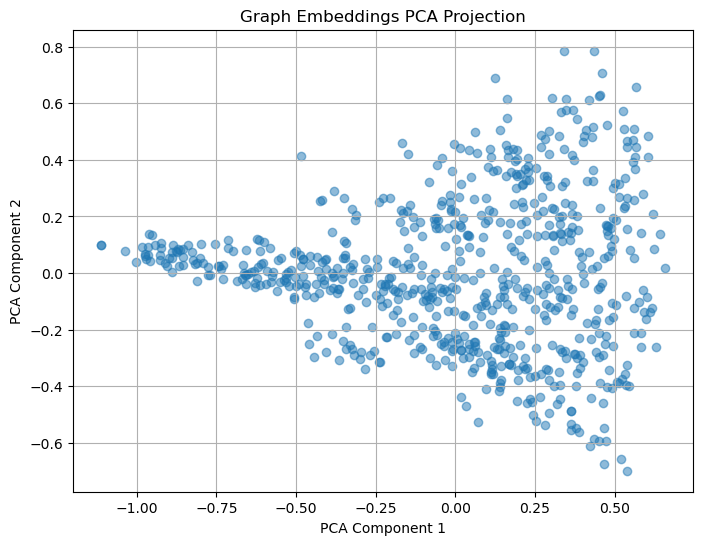

In [8]:
# Custom Graph2Vec implementation to avoid KarateClub dependency issues
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA

def custom_graph2vec(graphs, wl_iterations=3, embedding_dim=64):
    """
    Custom Graph2Vec implementation using Weisfeiler-Lehman kernel
    
    Args:
        graphs: List of networkx graphs
        wl_iterations: Number of WL iterations
        embedding_dim: Dimension of resulting embeddings
        
    Returns:
        numpy array with graph embeddings
    """
    # Convert PyG graphs to NetworkX if needed
    if not isinstance(graphs[0], nx.Graph):
        nx_graphs = [to_networkx(g, to_undirected=True) for g in graphs]
    else:
        nx_graphs = graphs
        
    # Initialize with node labels (use degrees as initial labels)
    documents = []
    node_labels = [{node: str(nx_graphs[i].degree(node)) for node in nx_graphs[i].nodes()}
                    for i in range(len(nx_graphs))]
    
    # WL iterations
    for _ in range(wl_iterations):
        # For each graph, create a document of vertex labels
        graph_documents = []
        new_node_labels = []
        
        for i, g in enumerate(nx_graphs):
            labels = node_labels[i]
            new_labels = {}
            doc = []
            
            # For each node, aggregate neighbor labels
            for node in g.nodes():
                neighbors = sorted([labels[nbr] for nbr in g.neighbors(node)])
                new_label = f"{labels[node]}_{'_'.join(neighbors)}"
                new_labels[node] = new_label
                doc.append(new_label)
                
            new_node_labels.append(new_labels)
            graph_documents.append(" ".join(doc))
        
        # Update node labels for next iteration
        node_labels = new_node_labels
        documents.extend(graph_documents)
    
    # Extract features using bag-of-words approach
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(documents)
    
    # Convert to TF-IDF features
    tfidf = TfidfTransformer()
    feature_matrix = tfidf.fit_transform(bow_matrix).toarray()
    
    # Reshape to get graph-level features (each WL iteration adds a document per graph)
    num_graphs = len(nx_graphs)
    graph_features = np.zeros((num_graphs, feature_matrix.shape[1]))
    
    for i in range(wl_iterations + 1):
        start_idx = i * num_graphs
        end_idx = (i + 1) * num_graphs
        if start_idx < feature_matrix.shape[0]:
            for j in range(num_graphs):
                if start_idx + j < feature_matrix.shape[0]:
                    graph_features[j] += feature_matrix[start_idx + j]
    
    # Reduce dimensions if needed
    if embedding_dim < graph_features.shape[1]:
        pca = PCA(n_components=embedding_dim)
        graph_features = pca.fit_transform(graph_features)
    
    return graph_features

train_embeddings = custom_graph2vec(train_graphs_subset, wl_iterations=3, embedding_dim=64)
val_embeddings = custom_graph2vec(val_graphs_subset, wl_iterations=3, embedding_dim=64)
test_embeddings = custom_graph2vec(test_graphs_subset, wl_iterations=3, embedding_dim=64)

print(f'Train embeddings shape: {train_embeddings.shape}')
print(f'Validation embeddings shape: {val_embeddings.shape}')
print(f'Test embeddings shape: {test_embeddings.shape}')
    
    # Visualize the first 2D PCA projection of the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(train_embeddings[:, 0], train_embeddings[:, 1], alpha=0.5)
plt.title('Graph Embeddings PCA Projection')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()



In [6]:
from graph2vec import Graph2Vec # Ensure this path is correct

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Graph2Vec model
g2v_model = Graph2Vec(
    wl_iterations=3,
    use_node_attribute='x', # Use 'x' for QM9 atom features, or None for degrees
    dimensions=32,
    workers=4,
    down_sampling=0.0001,
    epochs=10,
    learning_rate=0.025,
    min_count=5,
    seed=42,
    erase_base_features=False,
)

# Fit the model on the training data (NetworkX graphs)
g2v_model.fit(train_graphs_subset)

# Get embeddings for the training set
train_embeddings = g2v_model.get_embedding()

# Infer embeddings for validation and test sets
val_embeddings = g2v_model.infer(val_graphs_subset)
test_embeddings = g2v_model.infer(test_graphs_subset)

# Convert to PyTorch tensors - these are your X data
x_train = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
x_val = torch.tensor(val_embeddings, dtype=torch.float32).to(device)
x_test = torch.tensor(test_embeddings, dtype=torch.float32).to(device)

print(f'x_train shape: {x_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: torch.Size([700, 32])
x_val shape: torch.Size([150, 32])
x_test shape: torch.Size([150, 32])


In [7]:
# Indices for HOMO and LUMO in QM9 target properties
# HOMO is at index 2, LUMO is at index 3 (0-indexed)
target_indices = [2, 3]

# These are your Y data, selecting only HOMO and LUMO
y_train = torch.stack([data.y[0, target_indices] for data in train_pyg_subset]).to(device)
y_val = torch.stack([data.y[0, target_indices] for data in val_pyg_subset]).to(device)
y_test = torch.stack([data.y[0, target_indices] for data in test_pyg_subset]).to(device)

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')
print(f'x_train device: {x_train.device}, y_train device: {y_train.device}')

x_train shape: torch.Size([700, 32]), y_train shape: torch.Size([700, 2])
x_val shape: torch.Size([150, 32]), y_val shape: torch.Size([150, 2])
x_test shape: torch.Size([150, 32]), y_test shape: torch.Size([150, 2])
x_train device: cuda:0, y_train device: cuda:0


In [9]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

class MultiTargetMLP(nn.Module):
    def __init__(self, input_dim=15, hidden_dims=[64, 128, 64], output_dim=14):
        super(MultiTargetMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.Dropout(0.2))
            prev_dim = dim
            
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


In [10]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
model = MultiTargetMLP(input_dim=x_train.shape[1], output_dim=y_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training loop
n_epochs = 500
best_val_mse = float('inf')
patience = 50
counter = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val).item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val MSE: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_mse:
        best_val_mse = val_loss
        counter = 0
        # Save model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    test_preds = model(x_test).cpu().numpy()
    test_mse = mean_squared_error(y_test.cpu().numpy(), test_preds)
    print(f"Test MSE with MLP: {test_mse:.4f}")

Epoch 1/500, Train Loss: 22.5823, Val MSE: 22.5407
Epoch 2/500, Train Loss: 22.4665, Val MSE: 22.4285
Epoch 3/500, Train Loss: 22.2932, Val MSE: 22.2933
Epoch 4/500, Train Loss: 21.7017, Val MSE: 22.2834
Epoch 5/500, Train Loss: 21.6357, Val MSE: 21.9528
Epoch 6/500, Train Loss: 21.3413, Val MSE: 21.4806
Epoch 7/500, Train Loss: 21.0504, Val MSE: 21.0255
Epoch 8/500, Train Loss: 20.7581, Val MSE: 20.7017
Epoch 9/500, Train Loss: 20.6251, Val MSE: 20.4345
Epoch 10/500, Train Loss: 20.2030, Val MSE: 20.4728
Epoch 11/500, Train Loss: 19.9171, Val MSE: 20.3174
Epoch 12/500, Train Loss: 19.4424, Val MSE: 20.1281
Epoch 13/500, Train Loss: 19.0016, Val MSE: 19.7237
Epoch 14/500, Train Loss: 18.4438, Val MSE: 18.3760
Epoch 15/500, Train Loss: 17.9609, Val MSE: 16.9334
Epoch 16/500, Train Loss: 17.6049, Val MSE: 15.8905
Epoch 17/500, Train Loss: 16.7686, Val MSE: 15.1747
Epoch 18/500, Train Loss: 16.3192, Val MSE: 14.9499
Epoch 10/500, Train Loss: 20.2030, Val MSE: 20.4728
Epoch 11/500, Train L